In [27]:
# run this notebook on p2.xlarge instance 
# use docker image 
# docker pull jupyter/tensorflow-notebook
# docker tag jupyter/tensorflow-notebook:latest tensorflow-notebook
# docker run -it -p 8888:8888 -p 2222:22 -v ~:/home/ubuntu --name tensorflow-notebook tensorflow-notebook 

In [1]:
import os, shutil

In [2]:
base_dir = "/home/ubuntu/lambda-red-BIHGG/cats_and_dogs_small/"

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test') 

In [4]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 1000
total training dog images: 1000


In [6]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation cat images: 500
total validation dog images: 500


In [7]:
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test cat images: 500
total test dog images: 500


In [8]:
pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.9/site-packages
Requires: h5py, wheel, keras-preprocessing, astunparse, typing-extensions, absl-py, tensorflow-estimator, flatbuffers, six, protobuf, opt-einsum, termcolor, wrapt, numpy, tensorboard, grpcio, gast, google-pasta
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install keras==2.4.3
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.9/site-packages
Requires: numpy, h5py, scipy, pyyaml
Required-by: 


In [10]:
from keras import layers
from keras import models

In [11]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))


2021-08-23 21:21:25.090579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# look at the dimentions of the feature map changes with every succesive layer 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [13]:
# configure the model for training
# use RMSprop optimizer, because this network ends up with a single sigmoid unit 
from keras import optimizers
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])

In [14]:
# data preprocessing 
# using ImageDataGenerator to read images from direcories 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) # rescale all images by 1/255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory( 
    train_dir, # target directory 
    target_size=(150, 150), # resize all images to 150X150
    batch_size=20,
    class_mode='binary') # because we use binary_crossentropy loss, we need binary labels 

validation_generator = test_datagen.flow_from_directory( 
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
# the generator yields these batches indef- initely: 
# it loops endlessly over the images in the target folder. 
# For this reason, you need to break the iteration loop at some point:

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [16]:
# fit the model using a batch generator 

history = model.fit( 
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50) # took about 30min to run this 

2021-08-23 21:21:35.267035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-23 21:21:35.287231: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300035000 Hz


Epoch 1/30
100/100 [==============================] - 60s 593ms/step - loss: 0.6902 - acc: 0.5393 - val_loss: 0.6742 - val_acc: 0.5320
Epoch 2/30
100/100 [==============================] - 56s 563ms/step - loss: 0.6636 - acc: 0.5939 - val_loss: 0.6592 - val_acc: 0.5920
Epoch 3/30
100/100 [==============================] - 56s 563ms/step - loss: 0.6215 - acc: 0.6645 - val_loss: 0.6066 - val_acc: 0.6580
Epoch 4/30
100/100 [==============================] - 56s 558ms/step - loss: 0.5686 - acc: 0.6975 - val_loss: 0.6881 - val_acc: 0.6170
Epoch 5/30
100/100 [==============================] - 56s 562ms/step - loss: 0.5352 - acc: 0.7203 - val_loss: 0.5912 - val_acc: 0.6900
Epoch 6/30
100/100 [==============================] - 56s 557ms/step - loss: 0.4873 - acc: 0.7562 - val_loss: 0.5606 - val_acc: 0.7000
Epoch 7/30
100/100 [==============================] - 57s 569ms/step - loss: 0.4824 - acc: 0.7725 - val_loss: 0.5548 - val_acc: 0.7130
Epoch 8/30
100/100 [==============================] - 5

In [17]:
# saving the model 
model.save('cats_and_dogs_small_1.h5')

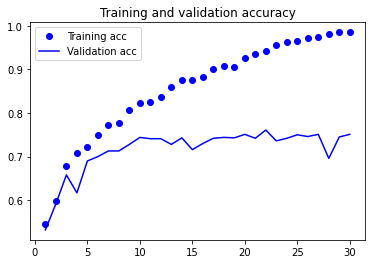

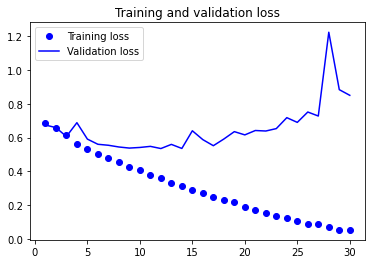

In [18]:
# plot the loss and accuracy of the model 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show() 

the training accuracy increases linearly over time, until it reaches 100%, whereas the validation accuracy stalls at 70-72%. The validation loss reaches its max after only five epochs and then stalls, whereas the training loss keeps decreasing until it reaches nearly 0. 

In [22]:
# using data augmentation 
# setting up data augmentation configuration via ImageDataGenerator
# Data augmentation takes the approach of generating more training data from existing training samples, 
# by augmenting the samples via a number of random transformations that yield believable-looking images.
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2, 
      height_shift_range=0.2, 
      shear_range=0.2, 
      zoom_range=0.2, 
      horizontal_flip=True, 
      fill_mode='nearest')

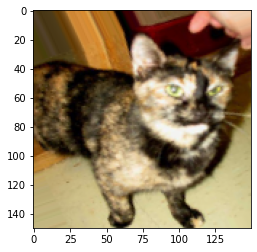

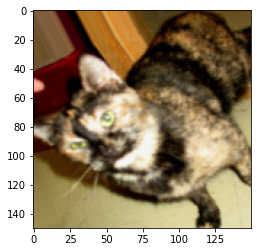

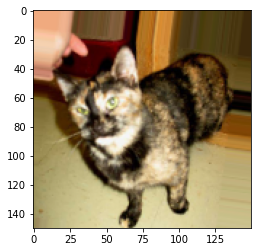

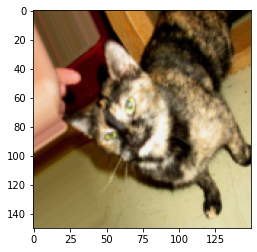

In [23]:
# display some randomly augmented training images 
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for # module with image-preprocessed utilities
          fname in os.listdir(train_cats_dir)]

img_path = fnames[3] # choose one image to augment

img = image.load_img(img_path, target_size=(150, 150)) # reads the image and resize it 

x = image.img_to_array(img) # converts to Numpy array with shape (150, 150 3)

x = x.reshape((1,) + x.shape) # reshape it to (1, 150, 150, 3)

# generate batches of randomly transformed images, loops indefinitely, 
# so you need to break the loop at some point
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0])) 
    i += 1
    if i % 4 == 0:
        break 

plt.show()

1) the inputs it sees are still heavily intercor- related, because they come from a small number of original images—you can’t pro- duce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. <br/>
2) To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

In [24]:
# defining a new convnet that includes dropout 
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu',
          input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5)) # dropout layer 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [25]:
# train the network using data augmentation and dropout 
# data augmentation 
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255) # note that the validation data should not be augmented


In [26]:
# preprocess the data to format them to the required size and type 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory( 
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
# model fit 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 61s 604ms/step - loss: 0.6922 - acc: 0.4969 - val_loss: 0.6905 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 60s 598ms/step - loss: 0.6814 - acc: 0.5601 - val_loss: 0.6614 - val_acc: 0.5940
Epoch 3/100
100/100 [==============================] - 60s 599ms/step - loss: 0.6705 - acc: 0.5815 - val_loss: 0.6453 - val_acc: 0.6150
Epoch 4/100
100/100 [==============================] - 60s 600ms/step - loss: 0.6754 - acc: 0.5805 - val_loss: 0.6909 - val_acc: 0.5490
Epoch 5/100
100/100 [==============================] - 60s 598ms/step - loss: 0.6513 - acc: 0.6221 - val_loss: 0.6134 - val_acc: 0.6540
Epoch 6/100
100/100 [==============================] - 60s 601ms/step - loss: 0.6404 - acc: 0.6187 - val_loss: 0.5977 - val_acc: 0.6710
Epoch 7/100
100/100 [==============================] - 59s 594ms/step - loss: 0.6204 - acc: 0.6572 - val_loss: 0.5789 - val_acc: 0.6800
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 60s 597ms/step - loss: 0.4312 - acc: 0.8118 - val_loss: 0.4857 - val_acc: 0.7750
Epoch 62/100
100/100 [==============================] - 60s 599ms/step - loss: 0.4309 - acc: 0.8090 - val_loss: 0.4922 - val_acc: 0.7730
Epoch 63/100
100/100 [==============================] - 60s 596ms/step - loss: 0.4477 - acc: 0.7880 - val_loss: 0.5155 - val_acc: 0.7620
Epoch 64/100
100/100 [==============================] - 60s 600ms/step - loss: 0.4474 - acc: 0.8071 - val_loss: 0.4446 - val_acc: 0.7830
Epoch 65/100
100/100 [==============================] - 60s 599ms/step - loss: 0.4230 - acc: 0.8163 - val_loss: 0.5001 - val_acc: 0.7610
Epoch 66/100
100/100 [==============================] - 61s 604ms/step - loss: 0.4466 - acc: 0.7882 - val_loss: 0.4487 - val_acc: 0.7960
Epoch 67/100
100/100 [==============================] - 60s 595ms/step - loss: 0.4181 - acc: 0.8000 - val_loss: 0.5029 - val_acc: 0.7620
Epoch 68/100
100/100 [===================

In [29]:
model.save('cats_and_dogs_small_2.h5')

In [ ]:
# plot out the result again 


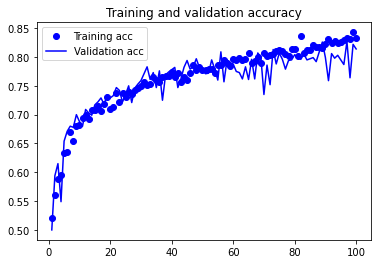

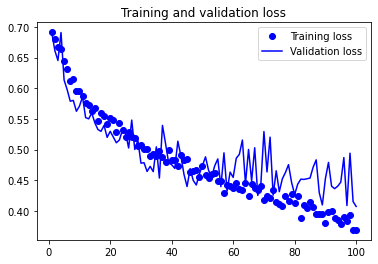

In [30]:
# plot the loss and accuracy of the model 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show() 

thanks to data augmentation and dropout, you're no longer overfitting. the training curves are closely tracking the validation curves. 

By using regularization techniques even futher, and by tuning the network's parameters, you may be able to get an even better accuracy, but it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. So the next step is to use a pretrained model. 

* use pretrained convnet

In [31]:
# feature extraction 
# instantiating the VGG16 convolutional base 
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [32]:
# detail of the architecture of the VGG16 convolutional base 
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [36]:
# fast feature extract without data augmentation 
# extract features using the pretrained convolutional base 
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/ubuntu/lambda-red-BIHGG/cats_and_dogs_small/' 
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) 
# class ImageDataGenerator is contained in Python, which can automatically
# turn image files on disk into batches of preprocessed tensors 
batch_size = 20


In [43]:
datagen.flow_from_directory

<bound method ImageDataGenerator.flow_from_directory of <tensorflow.python.keras.preprocessing.image.ImageDataGenerator object at 0x7f894d113df0>>

In [37]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, # target directory
        target_size=(150, 150), # resize all images to 150*150
        batch_size=batch_size, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        # don't understand how batch size 20 is kept in the final shape, maybe they are not, 
        # just the features are extracted in batches 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            # note that because generators yield data indefinitely in a loop, you must break 
            # after every image has been seen once 
    return features, labels 


In [38]:
train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [79]:
# need to feed them to a densely connected classifer, so first need to flatten them to (sample, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) 
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512)) 
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


In [80]:
# define and train the densely connected classifer 
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512)) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 2s 12ms/step - loss: 0.6983 - acc: 0.5888 - val_loss: 0.4366 - val_acc: 0.8550
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4501 - acc: 0.7878 - val_loss: 0.3724 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3773 - acc: 0.8359 - val_loss: 0.3172 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3315 - acc: 0.8537 - val_loss: 0.2950 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2739 - acc: 0.9020 - val_loss: 0.2905 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2701 - acc: 0.9037 - val_loss: 0.2708 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2519 - acc: 0.8975 - val_loss: 0.2687 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

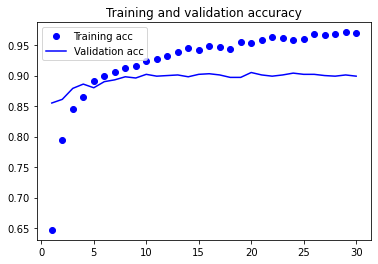

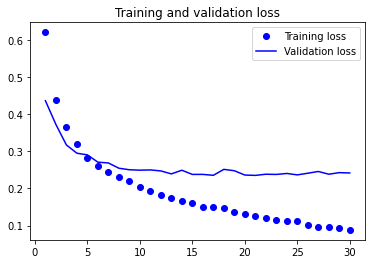

In [81]:
# look at the loss and accuracy curves during training 
# plot the result 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
# feature extraction with data augmentation 
# extending the conv_base model and running it end to end on the input 
# add a densely connected classifier on top of the convolutional base 
from keras import models
from keras import layers
model = models.Sequential() 
model.add(conv_base)
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))


In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [84]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [85]:
conv_base.trainable = False

In [86]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [87]:
# train the model end to end with a frozen convolutional base 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers

train_datagen = ImageDataGenerator( # data augmentation 
        rescale=1./255,
        rotation_range=40, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # Note that the validation data shouldn’t be augmented!

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [88]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


In [90]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30, 
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 326s 3s/step - loss: 0.2665 - acc: 0.8875 - val_loss: 0.3273 - val_acc: 0.8700
Epoch 2/30
100/100 [==============================] - 326s 3s/step - loss: 0.2853 - acc: 0.8830 - val_loss: 0.3267 - val_acc: 0.8450
Epoch 3/30
100/100 [==============================] - 326s 3s/step - loss: 0.2854 - acc: 0.8750 - val_loss: 0.3201 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 327s 3s/step - loss: 0.2812 - acc: 0.8770 - val_loss: 0.3435 - val_acc: 0.8470
Epoch 5/30
100/100 [==============================] - 326s 3s/step - loss: 0.2777 - acc: 0.8775 - val_loss: 0.3067 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 326s 3s/step - loss: 0.2800 - acc: 0.8785 - val_loss: 0.3011 - val_acc: 0.8750
Epoch 7/30
100/100 [==============================] - 326s 3s/step - loss: 0.2866 - acc: 0.8765 - val_loss: 0.3399 - val_acc: 0.8410
Epoch 8/30
100/100 [==============================] - 326s 3s/step - 

In [91]:
model.save('cats_and_dogs_small_test.h5')

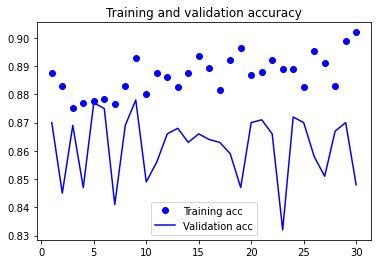

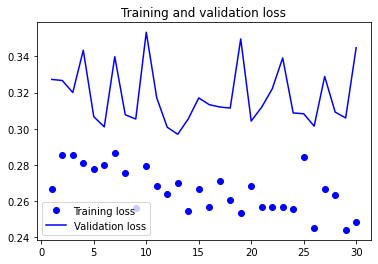

In [92]:
# plot out the results again 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show() # didn't see the 96% accuracy showed in the book, why??? 

* fine tuning <br/>
fine-tuning consist of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top model. 

In [93]:
# it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already
# been trained. 

# the steps for fine-tuning a network are as follows: 
# 1) add your custom network on top of an already-trained base network
# 2) freeze the base network 
# 3) train the part you added 
# 4) unfreeze some layers in the base network 
# 5) jointly train both these layers and the part you added 

# we already completed the first 3 steps when doing feature extraction. lets proceed with step 4. 
# unfreeze conv_base and then freeze individual layers inside it 

conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [94]:
# freezing all layers up to a specific one 
conv_base.trainable = True # unfreeze all 

set_trainable = False 
for layer in conv_base.layers:
    if layer.name == 'block5_conv1': 
        set_trainable = True
    if set_trainable: 
        layer.trainable = True
    else:
        layer.trainable = False
        

In [95]:
# fine-tuning the model 
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


In [ ]:
# takes too long to fit the model, stopped in the middle 
history = model.fit_generator( 
        train_generator,
        steps_per_epoch=100,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=50)


Epoch 1/100
100/100 [==============================] - 371s 4s/step - loss: 0.3066 - acc: 0.8583 - val_loss: 0.3147 - val_acc: 0.8640
Epoch 2/100
100/100 [==============================] - 369s 4s/step - loss: 0.2521 - acc: 0.8916 - val_loss: 0.3063 - val_acc: 0.8660
Epoch 3/100
100/100 [==============================] - 369s 4s/step - loss: 0.2078 - acc: 0.9079 - val_loss: 0.2971 - val_acc: 0.8650
Epoch 4/100
100/100 [==============================] - 370s 4s/step - loss: 0.1940 - acc: 0.9229 - val_loss: 0.2970 - val_acc: 0.8710
Epoch 5/100
100/100 [==============================] - 369s 4s/step - loss: 0.1943 - acc: 0.9101 - val_loss: 0.2957 - val_acc: 0.8830
Epoch 6/100
100/100 [==============================] - 370s 4s/step - loss: 0.1850 - acc: 0.9249 - val_loss: 0.2700 - val_acc: 0.8920
Epoch 7/100
100/100 [==============================] - 369s 4s/step - loss: 0.1610 - acc: 0.9425 - val_loss: 0.2552 - val_acc: 0.8940
Epoch 8/100
100/100 [==============================] - 369s 4s

In [97]:
# visualize what convnet learn 
# visualize intermediate activations: useful for understanding how successive convnet layers transform their input, 
# and for getting a first idea of the meaning of invidividual convnet filters 

# load the model saved in section 5.2
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [98]:
# proprossesing a single image 
img_path = '/home/ubuntu/lambda-red-BIHGG/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image 
import numpy as np

img = image.load_img(img_path, target_size=(150, 150)) 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


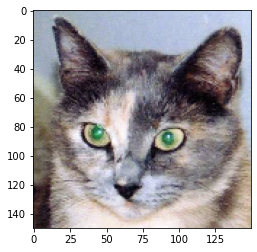

In [99]:
# display the test picture 
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0]) 
plt.show()

In [100]:
# instantiating a model from an input tensor and a list of output tensors 
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]] # extract output of the top 8 layers 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# creates a model that will return these outputs, given the model input 


In [101]:
# running the model in predict mode 
activations = activation_model.predict(img_tensor) 
# returns a list of eight numpy arrays, one array per layer activation


In [102]:
# this is the activation of the first convolution layer for the cat image input 
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


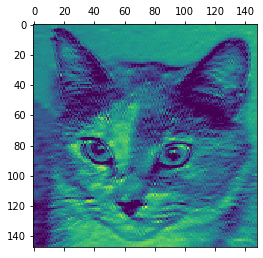

In [106]:
# visualize the fourth channel 
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

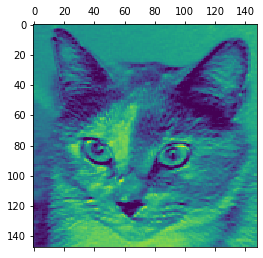

In [118]:
# seventh channel 
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [128]:
# visualizing every channel in every intermediate activation 
# name of the layers, so you can have them as part of your plot 



In [129]:
layer_names

['conv2d_4',
 'max_pooling2d_4',
 'conv2d_5',
 'max_pooling2d_5',
 'conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7']

In [125]:
activations[1].shape

(1, 74, 74, 32)

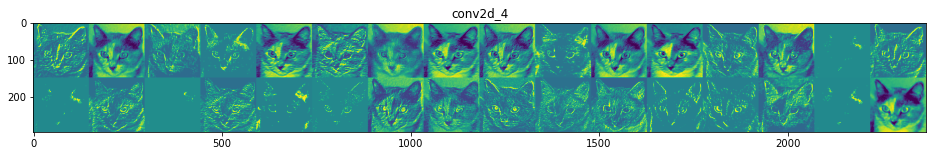

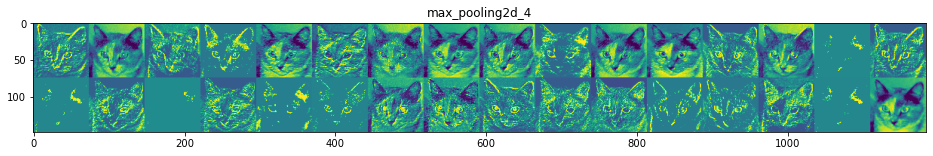

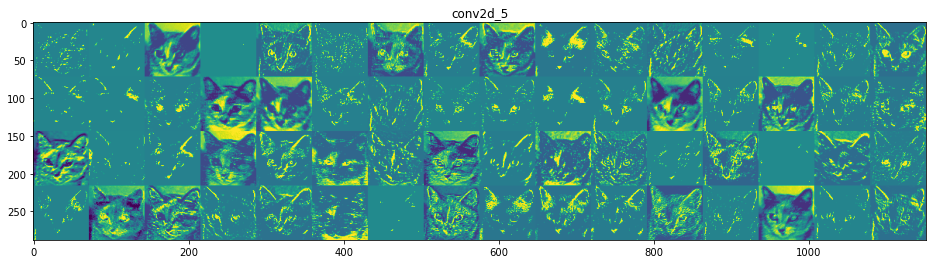

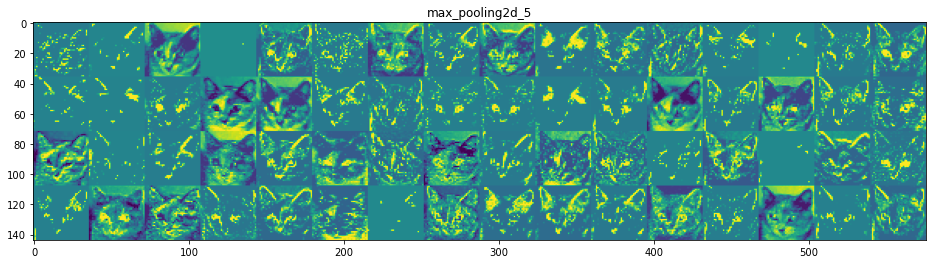

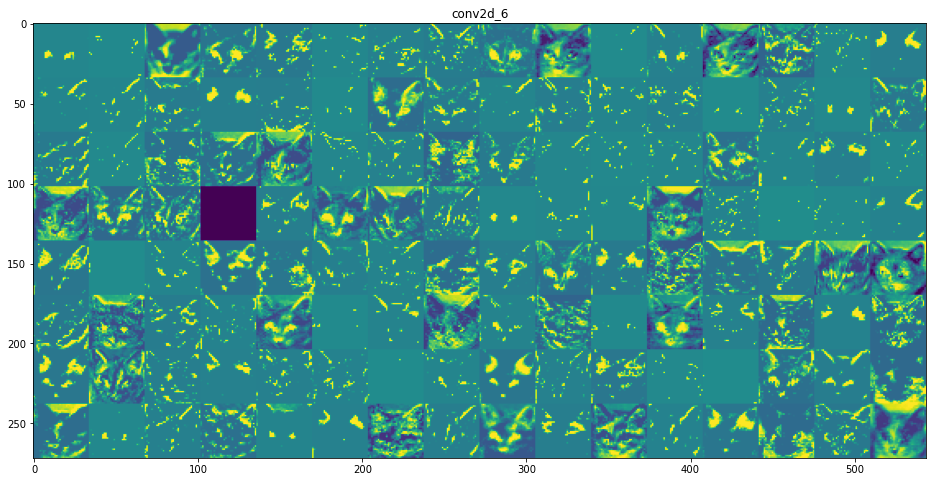

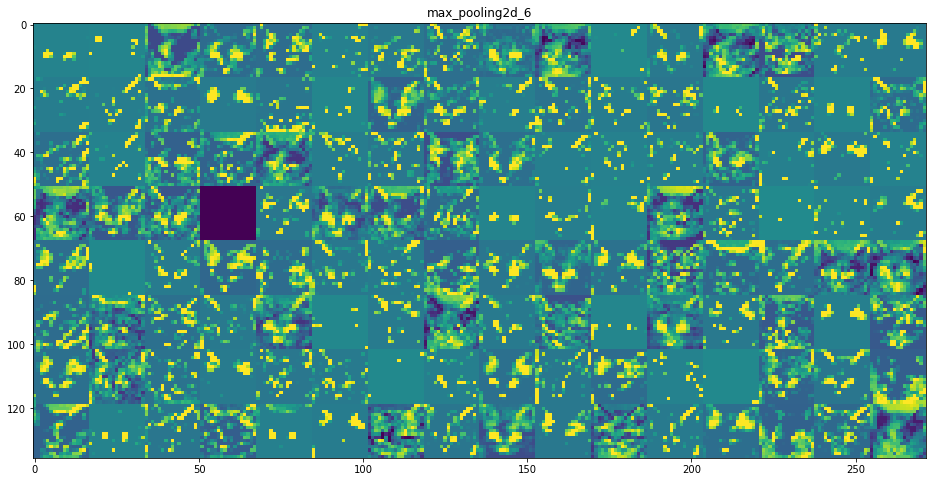

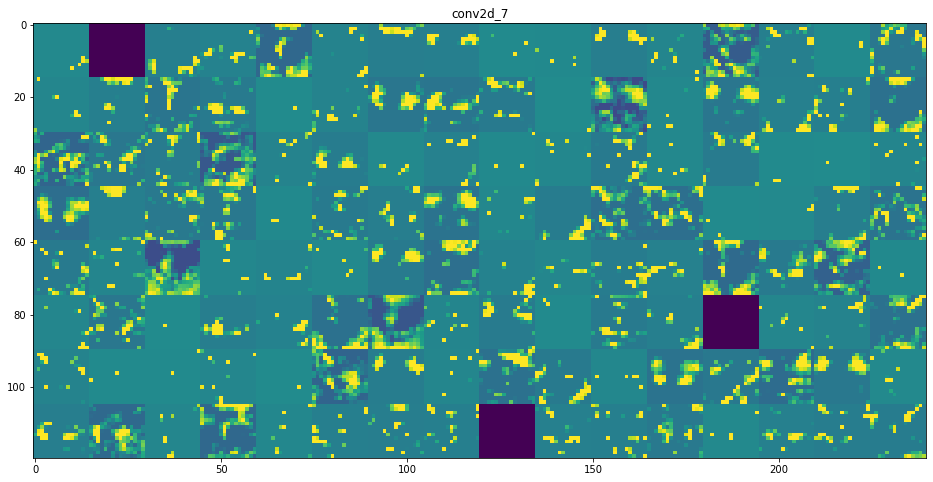

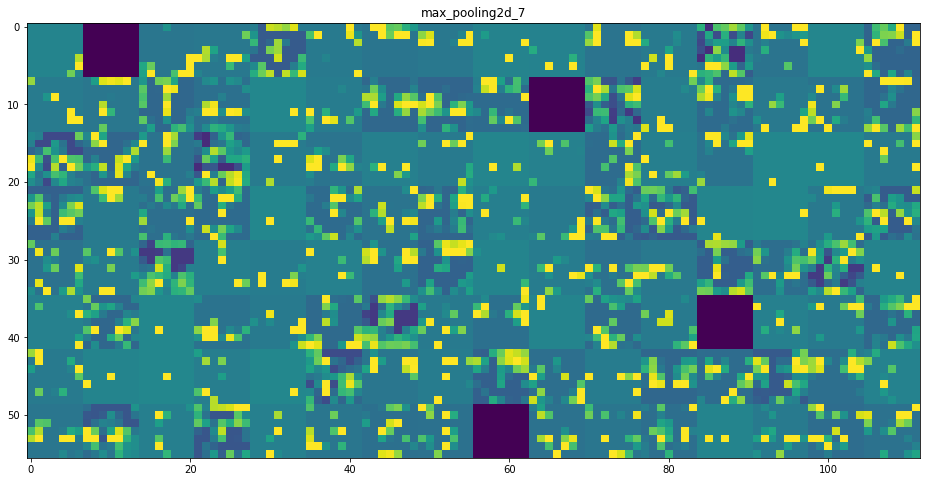

In [132]:
layer_names = []
for layer in model.layers[:8]: # the 1st 8 layers 
    layer_names.append(layer.name) 
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # number of features in the feature map, slice the last   
    
    size = layer_activation.shape[1] # the feature map has shape (I, size, size, n_feature)
    
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row] 
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0])) 
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [160]:
# visualize convnet filters 
# define the loss tensor for fitler visualization 
from keras.applications import VGG16 
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 

model = VGG16(weights='imagenet',
              include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output 
loss = K.mean(layer_output[:, :, :, filter_index])


2021-08-27 21:44:14.944411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


In [162]:
# obtaining the gradient of the loos with regard to the input 
grads = K.gradients(loss, model.input)[0]

In [163]:
# gradient-normalization trick, by dividing it by its L2 norms to help the gradient-descent process go smoothly 
# (the square root of the average of the square of the values in the tensor)

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [164]:
# fetch numpy output values given numpy input values 
iterate = K.function([model.input], [loss, grads])
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [178]:
# loss max via stochastic gradient descent 
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [180]:
# Listing 5.37 Utility function to convert a tensor into a valid image 

def deprocess_image(x): 
    x -= x.mean()
    x /= (x.std() + 1e-5) 
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [181]:
# function to generate filter visualization 
def generate_pattern(layer_name, filter_index, size=150): 
    layer_output = model.get_layer(layer_name).output 
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

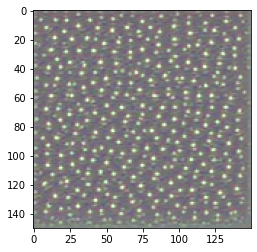

In [182]:
plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


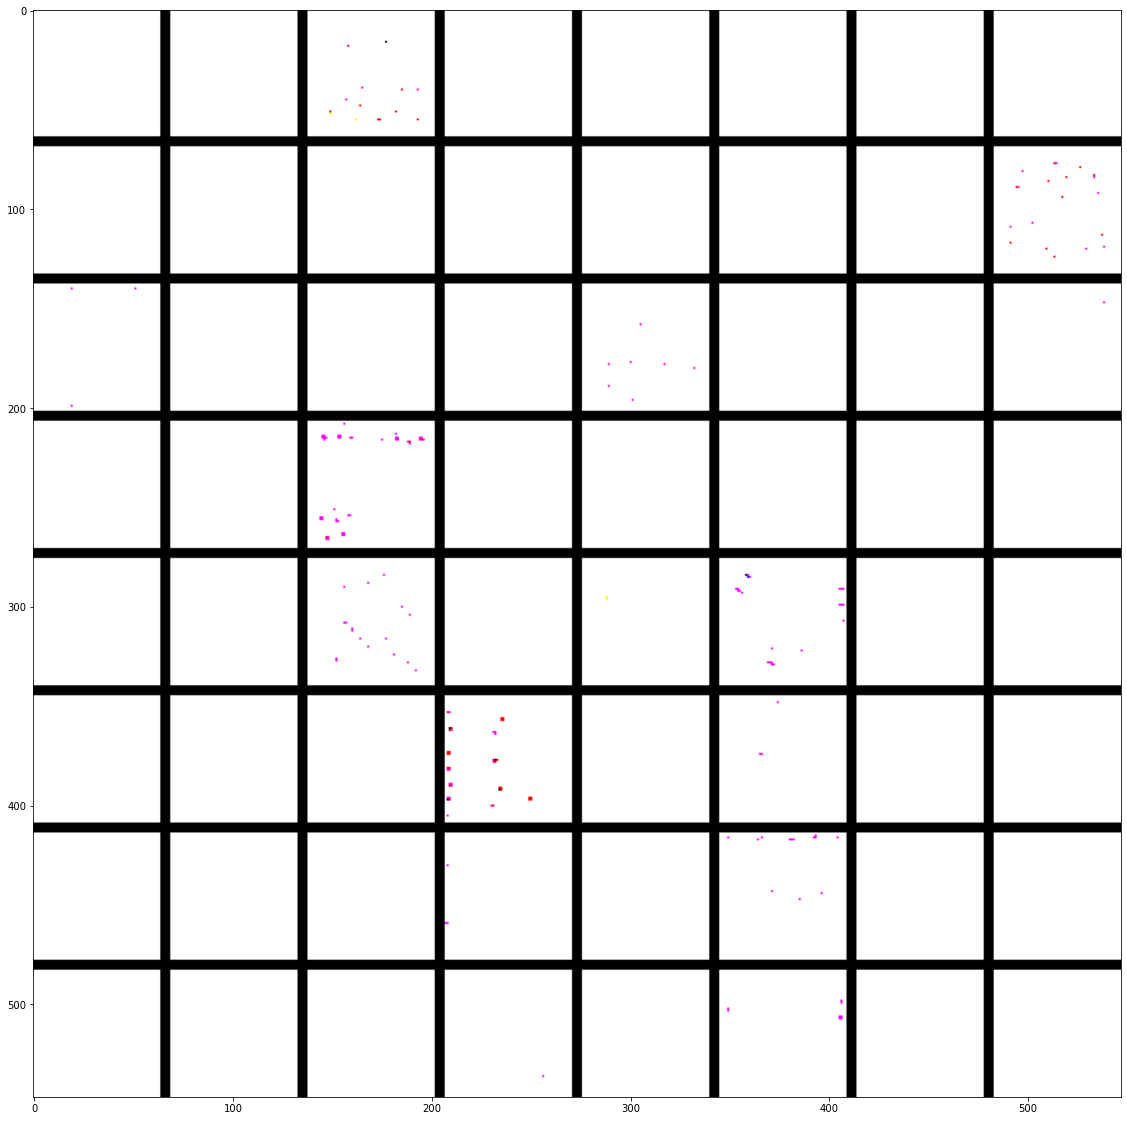

In [186]:
# generating a grid of all filter repsonse pattern in a layer 
layer_name = 'block3_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20)) 
plt.imshow(results)

In [ ]:
# visualize heatmap 

In [187]:
# loading the VGG16 network with pretrained weights 
from keras.applications.vgg16 import VGG16 
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


In [ ]:
# visualize the filter 
